# Segmenting and clustering neigborhoods in the city of Toronto, Canada

Segmentation of the neighborhoods of Toronto based on the category of nearby venues of each neighborhood. The information of the neighborhoods (postal code, borough and neighborhood) is extracted from Wikipedia as an html and stored in a pandas dataframe. Using geopy the latitude and longitude of each postal code is calculated. These geographical coordinates are used to search for nearby venues using foursquare and the category of each one is used to cluster the neighborhoods. The resulting clusters are showed in a folium map.

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
from IPython.display import display

from geopy.geocoders import Photon

import folium
from dotenv import load_dotenv, find_dotenv
import os

from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

### Obtain and preprocess the data

In [2]:
cols = ['PostalCode', 'Borough', 'Neighborhood']

In [3]:
# get info from wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

html = requests.get(url).text

In [4]:
# parse html
soup = BeautifulSoup(html, 'html.parser')

In [5]:
# clean info
data = {i:[] for i in cols}

for row in soup.find_all('table')[0].find_all('tr'):
    for cell in row.find_all('td'):
        
        postal_code = cell.text.strip()[:3]
        
        if cell.text.strip()[3:] == 'Not assigned':
            continue
        else:
            # not considered the case borough exists but neighborhood don't since it never happens
            # each postal code can have more than one neighborhood (sepparated by commas)
            borough = cell.text.strip()[3:cell.text.strip().find('(')]
            neighbourhood = cell.text.strip()[cell.text.strip().find('(')+1:].replace(' /', ',')\
            .replace(')', ' ')\
            .replace('(', ', ').strip()
        
        data['PostalCode'].append(postal_code)
        data['Borough'].append(borough)
        data['Neighborhood'].append(neighbourhood)


In [6]:
df_toronto = pd.DataFrame(data)
df_toronto.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [7]:
df_toronto.shape

(103, 3)

### Get latitude and longitude for each postal code

In [8]:
geolocator = Photon()

def get_lat_lng(postal_code):
    """
        This function returns (latitude, longitude) of a given postal code (str)
        in the city of Toronto, Ontario.
    """
    location = geolocator.geocode('{}, Toronto, Ontario'.format(postal_code))
    lat = location.latitude
    lng = location.longitude
    
    return lat, lng

In [9]:
# get latitude and longitude in one column
df_toronto['lat_lng'] = df_toronto['PostalCode'].apply(get_lat_lng)

In [10]:
# split latitude and longitude
lat_lng = list(df_toronto['lat_lng'])
lat = [i[0] for i in lat_lng]
lng = [i[1] for i in lat_lng]

In [11]:
df_toronto['Latitude'] = lat
df_toronto['Longitude'] = lng
df_toronto = df_toronto.drop('lat_lng', axis=1)

df_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753177,-79.339063
1,M4A,North York,Victoria Village,43.732658,-79.311189
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.664473,-79.366986
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.722778,-79.450933
4,M7A,Queen's Park,Ontario Provincial Government,43.775589,-79.502248


### Explore and cluster neighborhoods

All the neigborhoods are considered for clustering. Firstly a map is created to see all the neighborhoods that were found in the city of Toronto. Then nearby venues are searched for each neighborhood and the categories are used as features to fit the clustering algorithm. After trying to find the best number of clusters for the problem another map with the resulting clusters and a dataframe reporting the 5 most common venues categories in each neighborhood for each cluster are displayed.

In [12]:
# locate the city of Toronto
location = geolocator.geocode('Toronto, Ontario')
latitude = location.latitude
longitude = location.longitude

In [13]:
# create map of Toronto
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map based on neighborhoods
for lat, lng, label in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

map_toronto

In [14]:
# foursquare credentials
load_dotenv(find_dotenv())
CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")
VERSION = '20180605'
LIMIT = 100

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    """
        Returns a dataframe of nearby venues in each neighborhood
    """
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
toronto_venues = getNearbyVenues(
    df_toronto['Neighborhood'],
    df_toronto['Latitude'],
    df_toronto['Longitude']
)

toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753177,-79.339063,Donalda Golf & Country Club,43.752816,-79.342741,Golf Course
1,Parkwoods,43.753177,-79.339063,Corrosion Service Company Limited,43.752432,-79.334661,Construction & Landscaping
2,Parkwoods,43.753177,-79.339063,York Mills & Silverdale,43.756864,-79.341151,Bus Station
3,Parkwoods,43.753177,-79.339063,Variety Store,43.751974,-79.333114,Food & Drink Shop
4,Parkwoods,43.753177,-79.339063,TTC Stop #9075,43.757596,-79.338155,Train Station


In [17]:
# use venues categories as features
toronto_onehot = pd.get_dummies(toronto_venues['Venue Category'])
toronto_onehot['Neighborhood_'] = toronto_venues['Neighborhood']

# order columns
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood_,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# group the previous results by neighborhood to get just one row per neighborhood
toronto_grouped = toronto_onehot.groupby('Neighborhood_').mean().reset_index()
toronto_grouped.head()

,Neighborhood_,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# dataframe to store results
cols = ['Neighborhood', 
      '1st most common venue', 
      '2nd most common venue',
      '3rd most common venue',
      '4th most common venue',
      '5th most common venue']

toronto_segmented = pd.DataFrame(columns=cols)

toronto_segmented['Neighborhood'] = toronto_grouped['Neighborhood_']

for i in toronto_segmented.index:
    for j in range(1,6):
        toronto_segmented.loc[i,cols[j]] = toronto_grouped.iloc[i,1:].sort_values().index[-j]

toronto_segmented.head()

,Neighborhood,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue
0,Agincourt,Chinese Restaurant,Cantonese Restaurant,Coffee Shop,Food Court,Vietnamese Restaurant
1,"Alderwood, Long Branch",Bar,Bank,Park,Burger Joint,South American Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Electronics Store,Deli / Bodega,Pharmacy,Market,Zoo Exhibit
3,Bayview Village,Bank,Outdoor Supply Store,Fast Food Restaurant,Bubble Tea Shop,Sporting Goods Shop
4,"Bedford Park, Lawrence Manor East",Construction & Landscaping,Gym / Fitness Center,Zoo Exhibit,Fish & Chips Shop,Ethiopian Restaurant


In [39]:
toronto_clustering = toronto_grouped.drop('Neighborhood_', axis=1)

# search for the best number of clusters using elbow method
inertia = []

for i in range(1,11):
    model = KMeans(n_clusters=i, random_state=123)
    model.fit(toronto_clustering)
    
    inertia.append(model.inertia_)

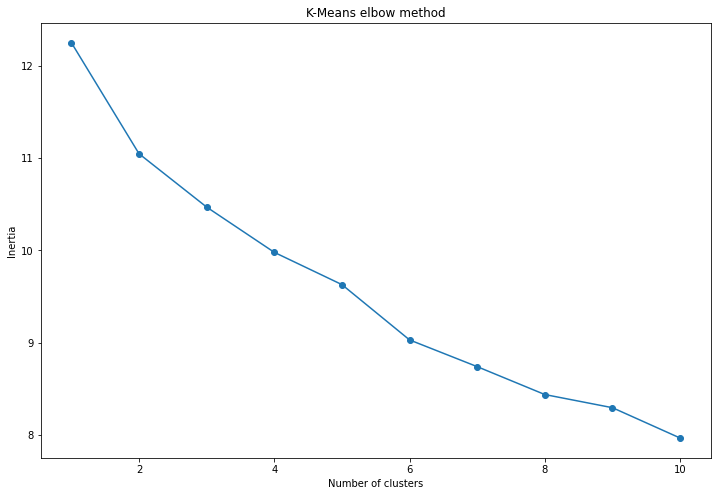

In [43]:
plt.figure(figsize=(12,8))
plt.plot(range(1,11), inertia, marker='o')

plt.title("K-Means elbow method")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")

plt.show()

In [48]:
# train with the "best" number of clusters
kclusters = 8
model = KMeans(n_clusters=kclusters, random_state=123).fit(toronto_clustering)

In [45]:
# update final dataframe
toronto_segmented = toronto_segmented.merge(df_toronto[['Latitude', 'Longitude', 'Neighborhood']], 
                                            on='Neighborhood',
                                            how='inner')
toronto_segmented['Label'] = model.labels_

toronto_segmented.head()

,Neighborhood,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,Latitude,Longitude,Label
0,Agincourt,Chinese Restaurant,Cantonese Restaurant,Coffee Shop,Food Court,Vietnamese Restaurant,43.785353,-79.278549,4
1,"Alderwood, Long Branch",Bar,Bank,Park,Burger Joint,South American Restaurant,43.593075,-79.541212,4
2,"Bathurst Manor, Wilson Heights, Downsview North",Electronics Store,Deli / Bodega,Pharmacy,Market,Zoo Exhibit,43.743944,-79.430851,5
3,Bayview Village,Bank,Outdoor Supply Store,Fast Food Restaurant,Bubble Tea Shop,Sporting Goods Shop,43.769197,-79.376662,2
4,"Bedford Park, Lawrence Manor East",Construction & Landscaping,Gym / Fitness Center,Zoo Exhibit,Fish & Chips Shop,Ethiopian Restaurant,43.737388,-79.410925,6


In [49]:
# create map of clustered neighborhoods
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, poi, cluster in zip(toronto_segmented['Latitude'], toronto_segmented['Longitude'], toronto_segmented['Neighborhood'], toronto_segmented['Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [61]:
# analyze venues categories of each cluster
for i in toronto_segmented['Label'].sort_values().unique():
    print("##### Cluster {} #####".format(i))
    display(toronto_segmented[toronto_segmented['Label']==i].iloc[:,1:6])
    

##### Cluster 0 #####


,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue
50,Park,Zoo Exhibit,Elementary School,Ethiopian Restaurant,Event Space
70,Park,Playground,Bike Trail,Fish & Chips Shop,Ethiopian Restaurant


##### Cluster 1 #####


,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue
15,Park,Caribbean Restaurant,Gas Station,Fish & Chips Shop,Ethiopian Restaurant
35,Home Service,Business Service,Arts & Crafts Store,Park,Bank
45,Caribbean Restaurant,Park,Coffee Shop,Convenience Store,Bank
47,Park,Convenience Store,Skating Rink,Bus Stop,Bakery
53,Park,Sandwich Place,Convenience Store,Japanese Restaurant,Escape Room
61,Garden,Photography Studio,Playground,Zoo Exhibit,Fish & Chips Shop
63,Bakery,Yoga Studio,Bar,Skating Rink,Fish & Chips Shop
66,Convenience Store,Grocery Store,Fast Food Restaurant,Sandwich Place,Restaurant
67,Construction & Landscaping,Train Station,Golf Course,Food & Drink Shop,Bus Station
72,Park,IT Services,Neighborhood,Fish & Chips Shop,Ethiopian Restaurant


##### Cluster 2 #####


,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue
3,Bank,Outdoor Supply Store,Fast Food Restaurant,Bubble Tea Shop,Sporting Goods Shop
6,Skating Rink,College Stadium,General Entertainment,Pizza Place,Food Court
10,Fast Food Restaurant,Coffee Shop,Discount Store,Sandwich Place,Toy / Game Store
14,Breakfast Spot,Department Store,Pizza Place,Sandwich Place,Food Truck
16,Ice Cream Shop,Pizza Place,Restaurant,Auto Garage,Pharmacy
23,Discount Store,Intersection,Chinese Restaurant,Department Store,Fast Food Restaurant
24,Vietnamese Restaurant,Bank,Pharmacy,Supermarket,Turkish Restaurant
26,Fast Food Restaurant,Pizza Place,Shopping Mall,Discount Store,Grocery Store
27,Park,Vietnamese Restaurant,Bank,Shopping Mall,Pizza Place
32,Pizza Place,Bank,Fast Food Restaurant,Discount Store,Zoo Exhibit


##### Cluster 3 #####


,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue
60,Bakery,Basketball Court,Fish Market,Event Space,Falafel Restaurant


##### Cluster 4 #####


,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue
0,Chinese Restaurant,Cantonese Restaurant,Coffee Shop,Food Court,Vietnamese Restaurant
1,Bar,Bank,Park,Burger Joint,South American Restaurant
5,Coffee Shop,Restaurant,Hotel,Seafood Restaurant,Gastropub
7,Soccer Stadium,Poutine Place,Performing Arts Venue,Theme Park,Athletics & Sports
8,Coffee Shop,Café,Airport Lounge,Airport Service,Airport Terminal
...,...,...,...,...,...
96,Korean Restaurant,Coffee Shop,Bubble Tea Shop,Dessert Shop,Park
98,Korean Restaurant,Greek Restaurant,Thai Restaurant,Middle Eastern Restaurant,Filipino Restaurant
99,Indian Restaurant,Bakery,Fish & Chips Shop,Cosmetics Shop,Furniture / Home Store
101,Restaurant,Coffee Shop,French Restaurant,Gym,Sandwich Place


##### Cluster 5 #####


,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue
2,Electronics Store,Deli / Bodega,Pharmacy,Market,Zoo Exhibit


##### Cluster 6 #####


,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue
4,Construction & Landscaping,Gym / Fitness Center,Zoo Exhibit,Fish & Chips Shop,Ethiopian Restaurant


##### Cluster 7 #####


,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue
55,Zoo Exhibit,Other Great Outdoors,Zoo,Gift Shop,Café


As we can see above some clusters are highly populated while others have only one or two instances. This seems to suggest that the difference between clusters is not that high and clustering the nighborhoods is not an easy duty. This fact is also seen in the graph of the "elbow method" to pick the best number of clusters, as we can see the graph still goes down if the number of clusters is increased, but always a slow decrease. There is not an evident point of inflexion or "elbow" in that curve, meaning that there is no ideal number of clusters.